# Update 2 - Flat Fields

Author: Johnny Esteves, University Of Michigan

### Description
Here I try to open and do a tree ring analysis of the flat fields



In [12]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()


import posixpath, datetime, sys
import cv2

import numpy

from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
# sys.path.append("/gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/mixcoatl/python")
sys.path.append("/gpfs/slac/kipac/fs1/u/esteves/codes/treeRingAnalysis/mixcoatl/python")

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from mixcoatl.characterizeSpots import CharacterizeSpotsTask
from mixcoatl.gridFitTask import GridFitTask

In [14]:
import os
import glob
import numpy as np
import fitsio as fits

# from scipy.stats import binnedstatistic, binned_statistic_2d

In [15]:
import numpy as np
import lsst.eotest.image_utils as imutils
import lsst.afw.image as afwImage
from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd

def make_ccd_mosaic(infile, bias_frame=None, gains=None, fit_order=1,dm_view=False):
    """Combine amplifier image arrays into a single mosaic CCD image array."""
    ccd = MaskedCCD(infile, bias_frame=bias_frame)
    datasec = parse_geom_kwd(ccd.amp_geom[1]['DATASEC'])
    nx_segments = 8
    ny_segments = 2
    nx = nx_segments*(datasec['xmax'] - datasec['xmin'] + 1)
    ny = ny_segments*(datasec['ymax'] - datasec['ymin'] + 1)
    mosaic = np.zeros((ny, nx), dtype=np.float32) # this array has [0,0] in the upper right corner on LCA-13381 view o
     
    for ypos in range(ny_segments):
        for xpos in range(nx_segments):
            amp = ypos*nx_segments + xpos + 1      
            detsec = parse_geom_kwd(ccd.amp_geom[amp]['DETSEC'])
            xmin = nx - max(detsec['xmin'], detsec['xmax'])
            xmax = nx - min(detsec['xmin'], detsec['xmax']) + 1
            ymin = ny - max(detsec['ymin'], detsec['ymax'])
            ymax = ny - min(detsec['ymin'], detsec['ymax']) + 1
            #
            # Extract bias-subtracted image for this segment - overscan not corrected, since we don't pass overscan he
            #
            segment_image = ccd.unbiased_and_trimmed_image(amp, fit_order=fit_order)
            subarr = segment_image.getImage().getArray()
            #
            # Determine flips in x- and y- direction
            #
            if detsec['xmax'] > detsec['xmin']: # flip in x-direction
              subarr = subarr[:, ::-1]
            if detsec['ymax'] > detsec['ymin']: # flip in y-direction
              subarr = subarr[::-1, :]
            #
            # Convert from ADU to e-
            #
            if gains is not None:
              subarr *= gains[amp]
            #
            # Set sub-array to the mosaiced image
            #
            mosaic[ymin:ymax, xmin:xmax] = subarr  
    if dm_view:
      # transpose and rotate by -90 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower') rotated CW by 90 for DM view
      mosaicprime = np.zeros((ny, nx), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=-1)    
      image = afwImage.ImageF(mosaicprime)  
    else:
      # transpose and rotate by 180 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower')
      mosaicprime = np.zeros((nx, ny), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=2)    
      image = afwImage.ImageF(mosaicprime)  
    
    return image
      

In [16]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(obj=None, ax=None, size="5%", pad=0.1):
    should_restore = False

    if obj is not None:
        ax = obj.axes
    elif ax is None:
        ax = plt.gca()
        should_restore = True

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)

    plt.colorbar(obj, cax=cax)

    if should_restore:
        plt.sca(ax)
        
def imshow(image, qq=[0.5,97.5], show_colorbar=True, **kwargs):
    vmin1,vmax1 = np.percentile(image[np.isfinite(image)], qq)
    if 'vmin' not in kwargs.keys():
        kwargs['vmin'] = vmin1
    if 'vmax' not in kwargs.keys():
        kwargs['vmax'] = vmax1
    plt.imshow(image, **kwargs)
    if show_colorbar:
        colorbar()

In [17]:
import numpy
import scipy

def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = (A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    
    return numpy.lib.stride_tricks.as_strided(A, shape=np.array(shape).astype(int), strides=np.array(strides).astype(int))

def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

def zero_by_region(data, region_shape, num_sigmas_clip=8.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks  = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                #region_data[:] = gaussian_filter(region_data.copy(), 2.)
                region_data[~region_mask] = clipped_data
                
    return levels.T, mask
def get_diff_lowpass(image, size=250, power=4.0, use_zero=True, geometry=(2,8)):
    if use_zero:
        image1 = image.copy()
        levels,mask = zero_by_region(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

        return image1/image
    else:
        diff = apply_filter(image, size, power=power)
        
        res = np.where(image==0, 0., diff/image)
        return res

# Load Data

Retrieving files path from BUTLER.

In specific, for loading the results after the corrections made on the mixcoatl code by Alex I use the repo_path used `/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml` and the collection `u/youtsumi/spot/AlexRecommendation`.


### Super Flat Files

In [18]:
itl = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_median_sflat.fits' 
itl2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_dark_pixel_mask.fits' 
itl = itl%(205)
itl2= itl2%(205)

etv = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_median_sflat.fits' 
etv2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_dark_pixel_mask.fits' 
etv = etv%(382)
etv2= etv2%(382)

In [2]:
!ls /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/*

/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-157_dark_pixel_mask.fits
/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-157_median_sflat.fits
/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-160_dark_pixel_mask.fits
/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-160_median_sflat.fits
/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-205_dark_pixel_mask.fits
/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-205_median_sflat.fits
/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/I

# ITL Tree Ring Center

### Load Data

In [22]:
image = np.rot90(make_ccd_mosaic(itl).getArray())
mask  = np.rot90(make_ccd_mosaic(itl2).getArray())
image[mask>0] = 0.

In [23]:
image.shape

(4000, 4072)

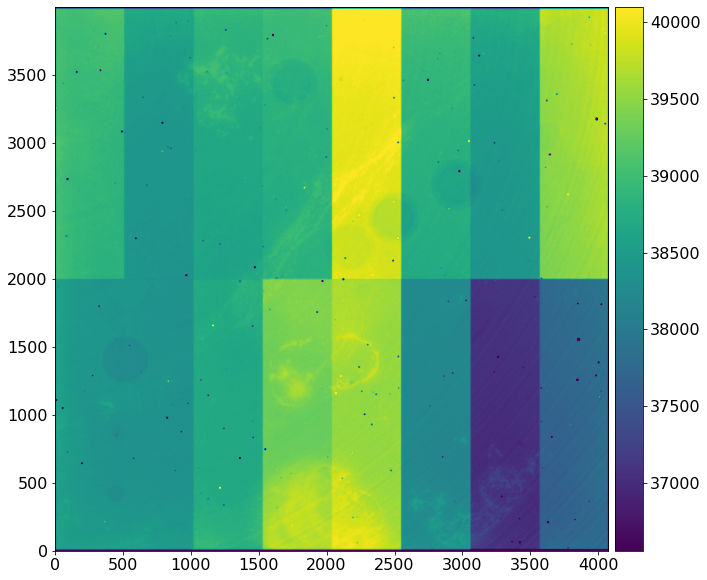

In [24]:
imshow(image)

### High Pass Filter

<ipython-input-17-e4984341c21e>:89: RuntimeWarning: divide by zero encountered in true_divide
  return image1/image


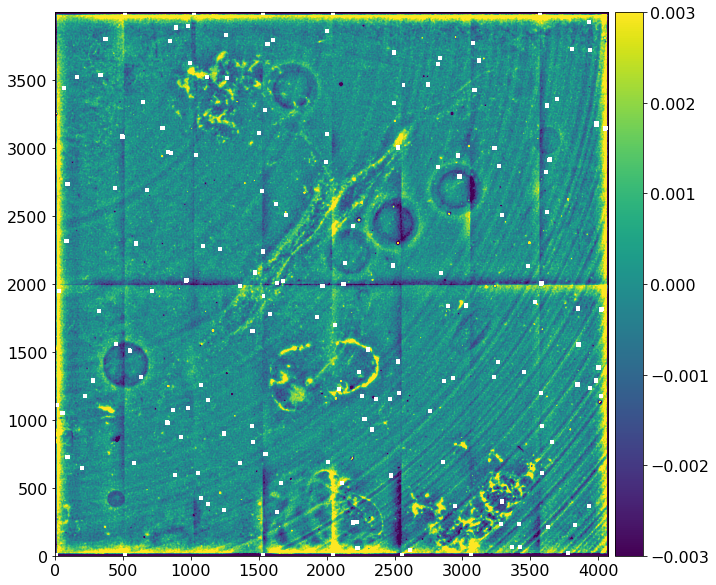

In [25]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.003,vmax=0.003)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

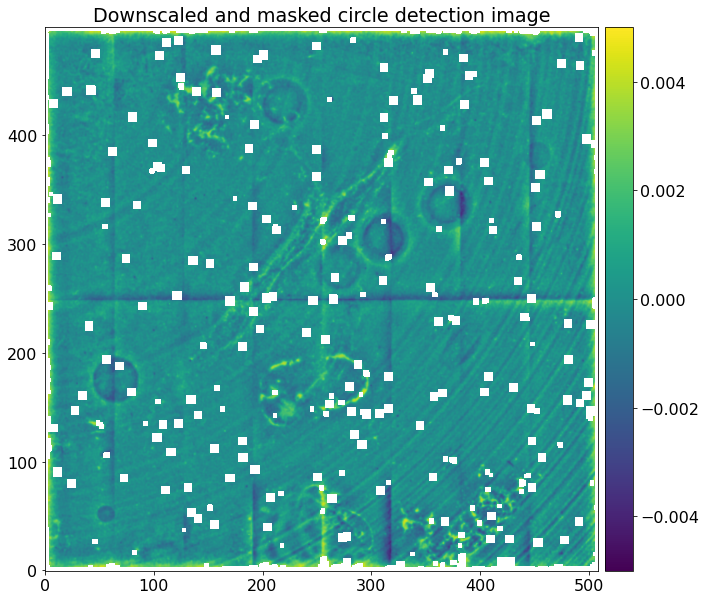

In [69]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.001 # For stronger rings
threshold = 0.005 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 4.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.mean)
mask2 = block_reduce(mask, (downscale, downscale), func=np.max)
diff2[mask2] = np.nan

imshow(diff2, interpolation='bicubic', vmin=-0.005, vmax=0.005)#
plt.title('Downscaled and masked circle detection image')

### Finding the CCD Center

In [12]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.mean(r), np.max(r), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

In [13]:
xlow, xhig = -800., 0.
ylow, yhig = 4000., 4800.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.000550122747505072
 message: 'Optimization terminated successfully.'
    nfev: 803
     nit: 9
 success: True
       x: array([-38.89001497, 510.92588152])

Original scale coordinates: -311.12, 4087.41


### Diagnostic Plots

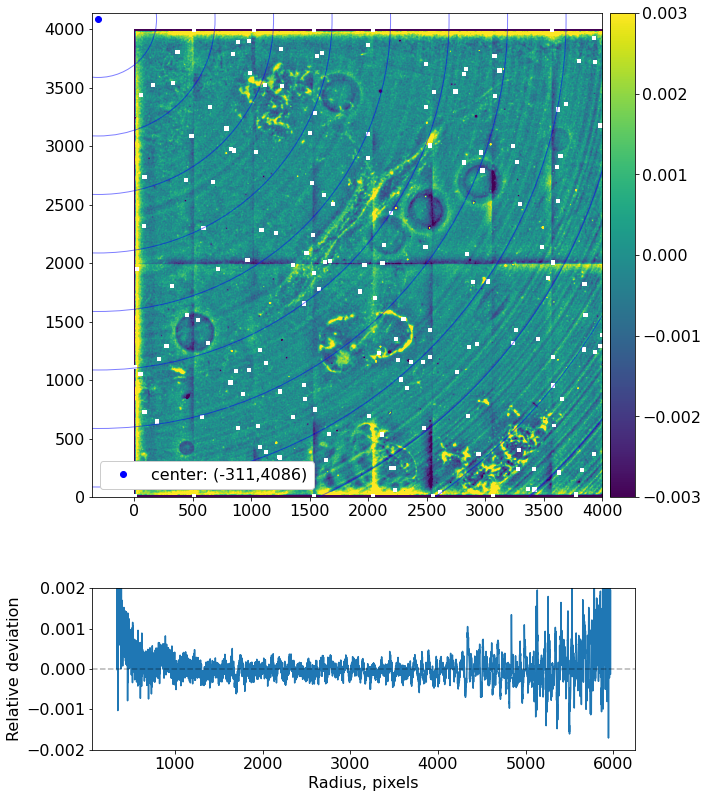

In [208]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.003, vmax=0.003)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 6000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.xlim(x0-50,4200)
# plt.ylim(-50,y0+50)

plt.xlim(x0-50,4000)
plt.ylim(0., y0+50)

# plt.show()

# Now make less restrictive mask
mask = np.abs(diff1) > 0.002

pos,v = fn_measure(x0, y0, mask=mask, step=1.0, statistic='mean')
# plt.subplot(211)
plt.subplot2grid((4,1),(3,0), rowspan=1)

plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.002, 0.002)
plt.tight_layout()

(5100.0, 6248.928819425656)

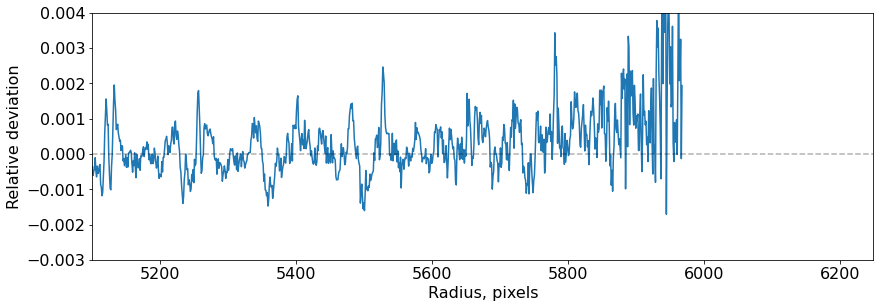

In [209]:
plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.003, 0.004)
plt.xlim(5100,)

Will analyse the following radial interval: 1463 - 5911 pixels


<ipython-input-210-fecaddf4d32e>:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


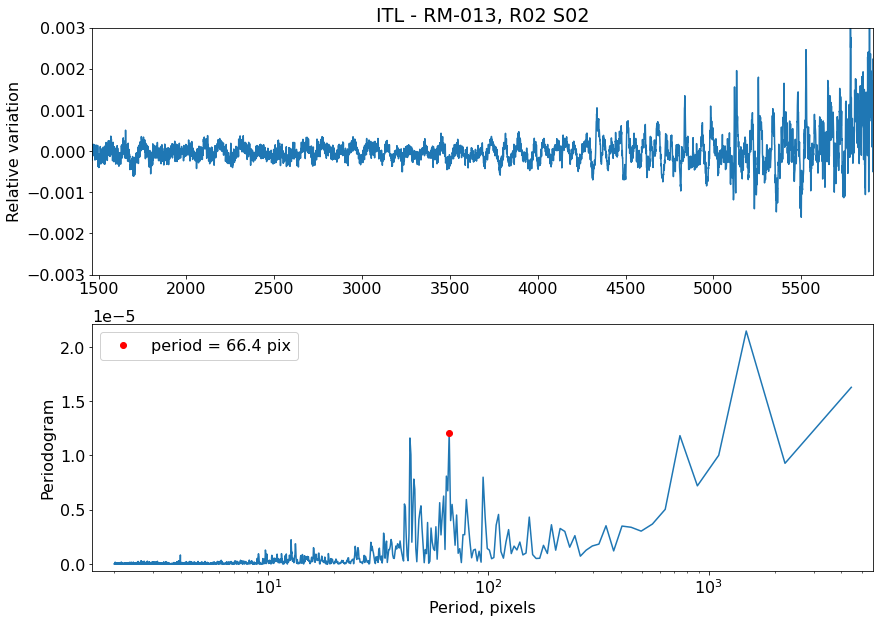

In [210]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylim(-0.003,0.003)
plt.ylabel('Relative variation')
plt.title('ITL - RM-013, R02 S02')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

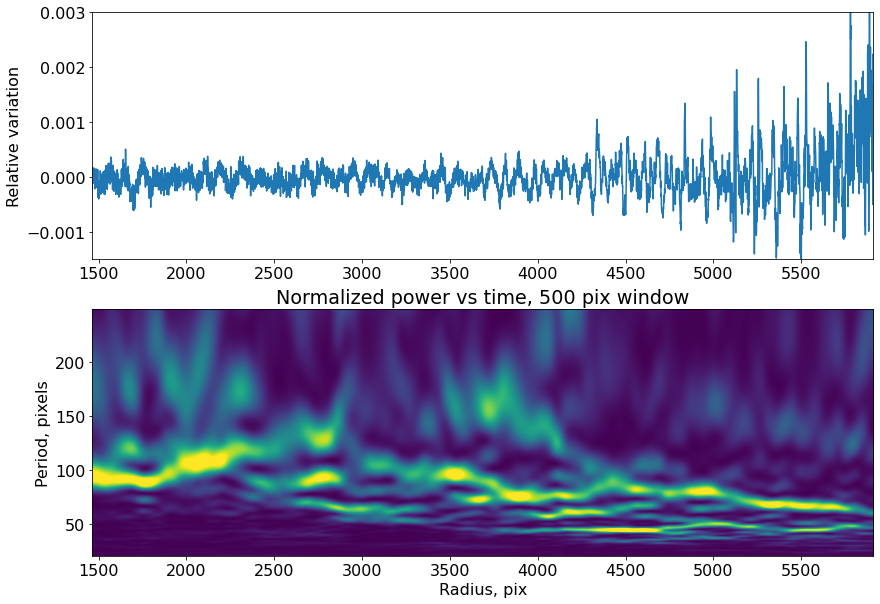

In [211]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


<ipython-input-212-deb69ba41938>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


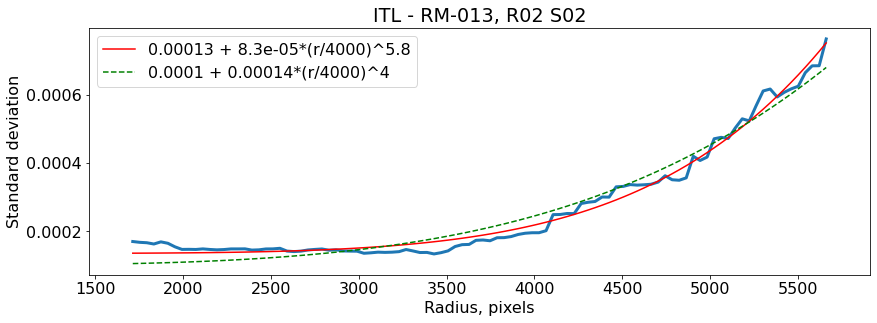

In [212]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('ITL - RM-013, R02 S02')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)

# E2V Tree Ring Center

### Load Data

In [8]:
image = np.rot90(make_ccd_mosaic(etv).getArray())
mask  = np.rot90(make_ccd_mosaic(etv2).getArray())
image[mask>0] = 0.

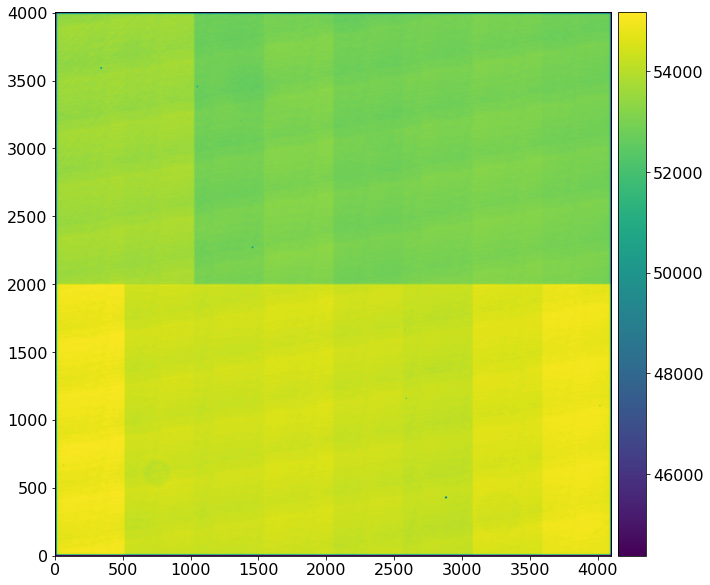

In [9]:
imshow(image)

In [11]:
image.shape

(4004, 4096)

### High Pass Filter

<ipython-input-6-e4984341c21e>:89: RuntimeWarning: divide by zero encountered in true_divide
  return image1/image


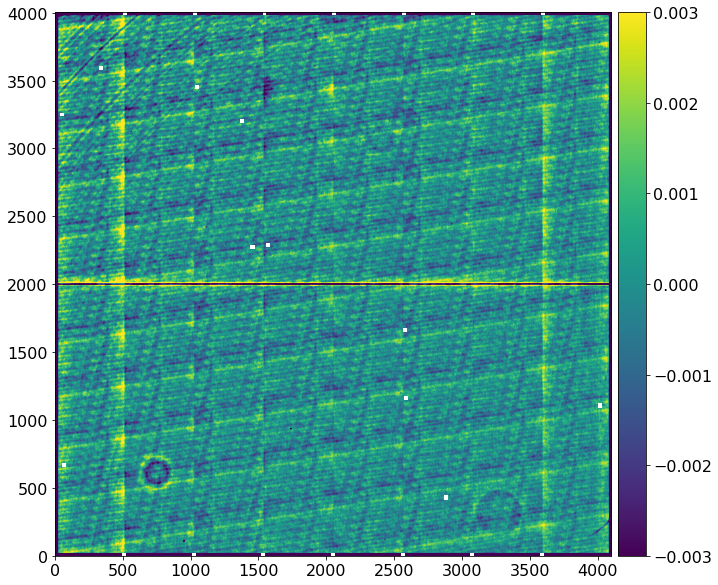

In [10]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.003,vmax=0.003)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

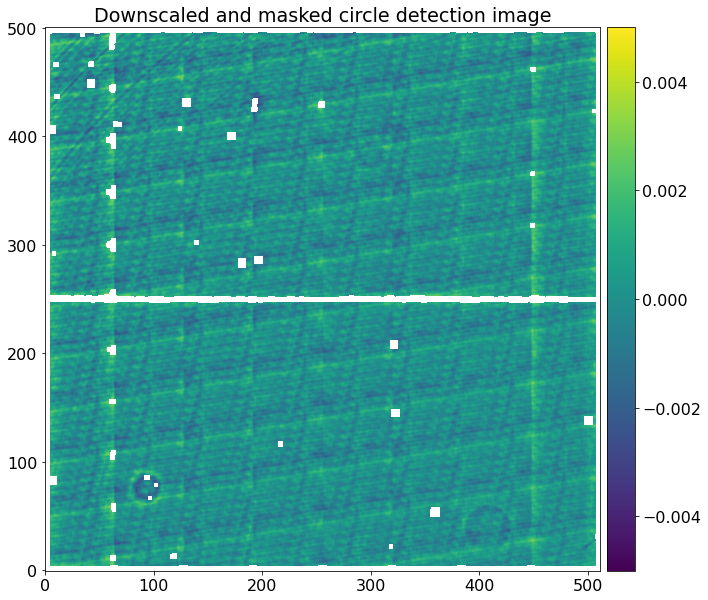

In [226]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.001 # For stronger rings
threshold = 0.0035 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 4.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.mean)
mask2 = block_reduce(mask, (downscale, downscale), func=np.max)
diff2[mask2] = None

imshow(diff2, interpolation='bicubic', vmin=-0.005, vmax=0.005)#
plt.title('Downscaled and masked circle detection image')

### Finding the CCD Center

In [227]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.mean(r), np.max(r), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

In [228]:
ylow, yhig = -500., 0.
xlow, xhig = 4000., 4500.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.00029201404541788896
 message: 'Optimization terminated successfully.'
    nfev: 563
     nit: 6
 success: True
       x: array([554.9046432 , -54.32806153])

Original scale coordinates: 4439.24, -434.62


### Diagnostic Plots

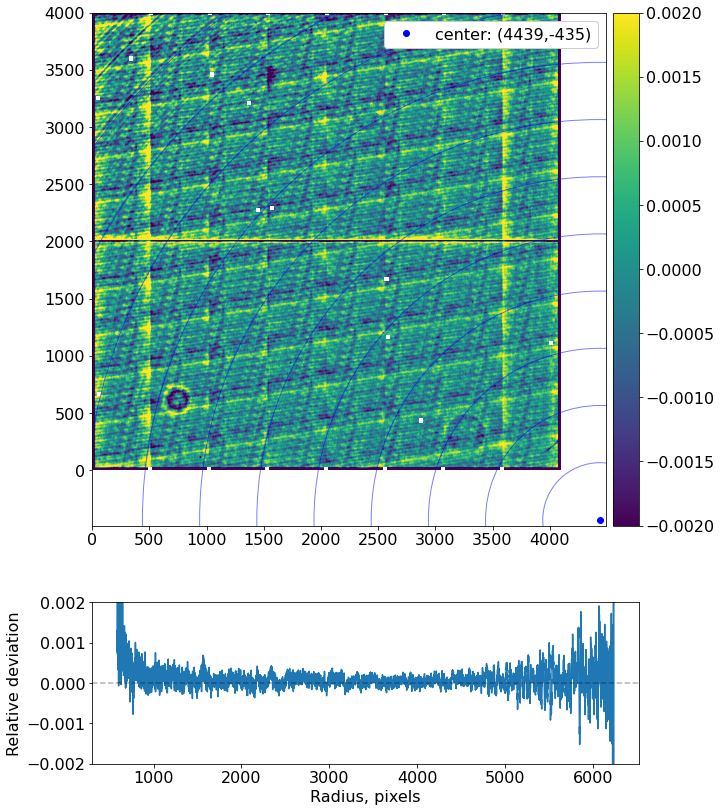

In [229]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.002, vmax=0.002)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 6000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.xlim(x0-50,4200)
# plt.ylim(-50,y0+50)

plt.ylim(y0-50,4000)
plt.xlim(0., x0+50)

# plt.show()

# Now make less restrictive mask
mask = np.abs(diff1) > 0.002

pos,v = fn_measure(x0, y0, mask=mask, step=1.0, statistic='mean')
# plt.subplot(211)
plt.subplot2grid((4,1),(3,0), rowspan=1)

plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.002, 0.002)
plt.tight_layout()

(5100.0, 6515.334542314662)

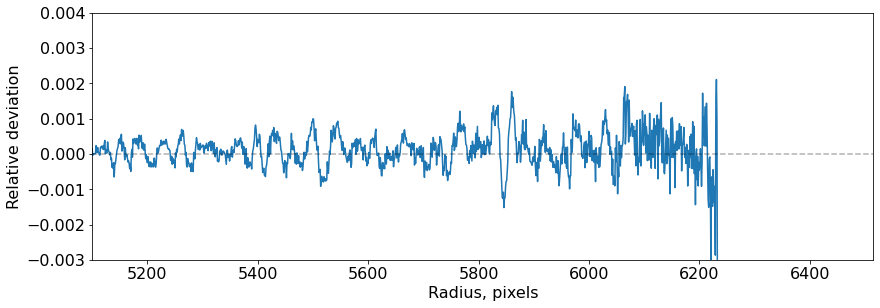

In [230]:
plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.003, 0.004)
plt.xlim(5100,)

Will analyse the following radial interval: 1715 - 6007 pixels


<ipython-input-231-42fb409ea4f5>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


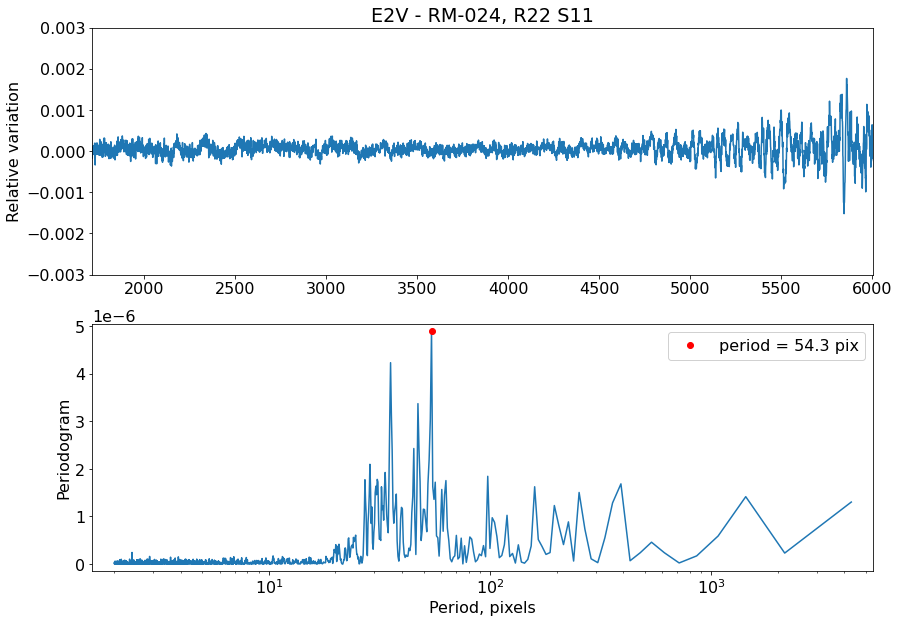

In [231]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.ylim(-0.003, 0.003)
plt.title('E2V - RM-024, R22 S11')

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

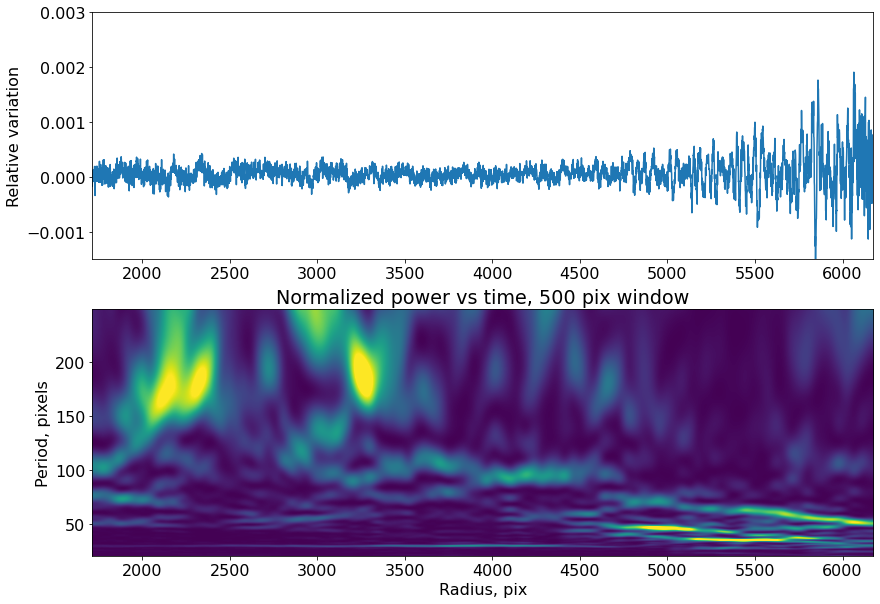

In [232]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


In [2]:
r4000 = 0.0017+0.00075
g4000 = 6.6e-5+4.7e-5

ratio = r4000/g4000
print(ratio)

21.68141592920354


<ipython-input-233-57fd0f3833f5>:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


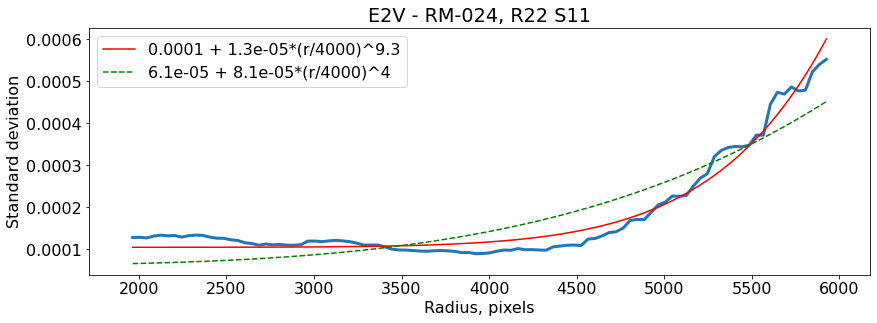

In [233]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('E2V - RM-024, R22 S11')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)

In [129]:
help(tree_ring_tools)

Help on class tree_ring_tools in module generate_sinal_profile:

class tree_ring_tools(builtins.object)
 |  tree_ring_tools(sensor='e2v', loc=0, maxR=6000)
 |  
 |  Generates tree ring profiles for a given image
 |  
 |  paramters:
 |  sensor  : str - 'e2v' or 'itl'
 |  loc     : int - orientation of the ring pattern, 0,1,2,3 corresponds to (A,B,C,D) see paper ...
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sensor='e2v', loc=0, maxR=6000)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  apply_gaussian_filter(self, downscale=2.0)
 |  
 |  apply_high_freq_filter(self, smoothness=250, power=4.0)
 |  
 |  apply_mask(self, downscale=2, threshold=0.05)
 |  
 |  check_ccd_center_plot(self, image, xc=None, yc=None, xlims=(800, 4370), ylims=(-320, 3500), levels=None)
 |  
 |  check_polar_transfomartion(self, r_cut=None, theta_cut=None)
 |  
 |  compute_signal(self, wfilter=False, freq=340)
 |  
 |  display_images(self)
 |  
 |  make_image(self, spot_gri

# Astrometric Shift Analysis

## X direction

In [48]:
from generate_sinal_profile import tree_ring_tools

In [49]:
sensor = 'ITL'

In [50]:
sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}

xmax = sensor_lims[sensor][0][1]
ymax = sensor_lims[sensor][1][1]

In [51]:
import cv2

diff00 = cv2.resize(diff,(xmax,ymax), interpolation = cv2.INTER_AREA)
diff11 = cv2.resize(diff1,(xmax,ymax), interpolation = cv2.INTER_AREA)
diff22 = cv2.resize(diff2,(xmax,ymax), interpolation = cv2.INTER_AREA)

In [52]:
ring_dx = tree_ring_tools(sensor=sensor,loc=2)

In [57]:
ring_dx.img_cut = image
ring_dx.img     = image

In [58]:
ring_dx.diff = diff00
ring_dx.diff1= diff11
ring_dx.diff2= diff22

In [60]:
## always run in the following order
# ring_dx.apply_high_freq_filter()
# ring_dx.apply_gaussian_filter(downscale=8)
# ring_dx.apply_mask(downscale=8,threshold=0.005)

ring_dx.set_ylabel(r'dX [pixel]')
ring_dx.set_levels([-0.003,0.003])
# ring_dx.display_images()

In [61]:
ring_dx.xc = x0
ring_dx.yc = y0

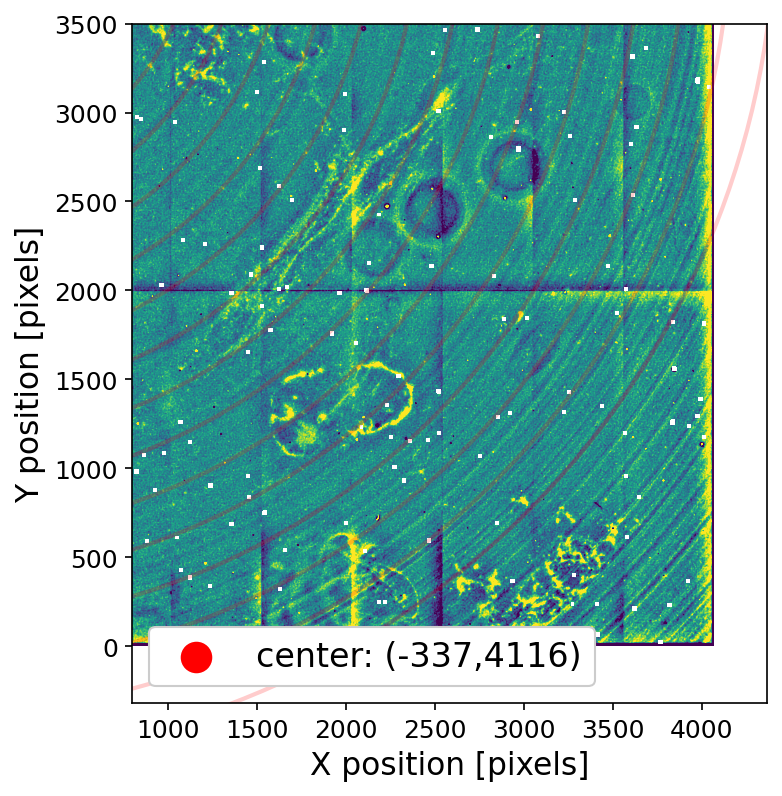

In [62]:
ring_dx.check_ccd_center_plot(ring_dx.diff,ring_dx.xc,ring_dx.yc)

In [63]:
def nanzero(img):
    img[np.where(img==0)] = np.nan
    return img

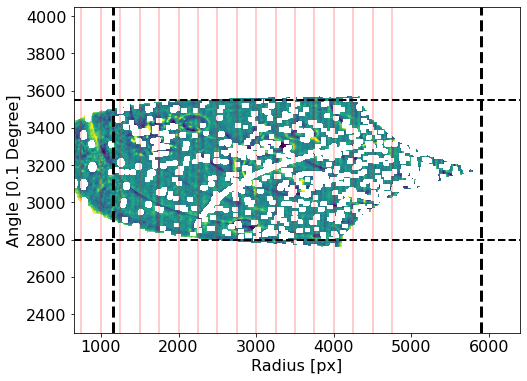

In [70]:
ring_dx.make_polar_transformation(r_cut=(1150,5900),theta_cut=(2800,3550))

ring_dx.polar_cut = nanzero(ring_dx.polar_cut)
ring_dx.polar_img = nanzero(ring_dx.polar_img)
ring_dx.set_levels([-0.0015,0.0015])
ring_dx.check_polar_transfomartion()

In [80]:
ring_dx.compute_signal()
# ring_dx.plot_pannel_image_signal()

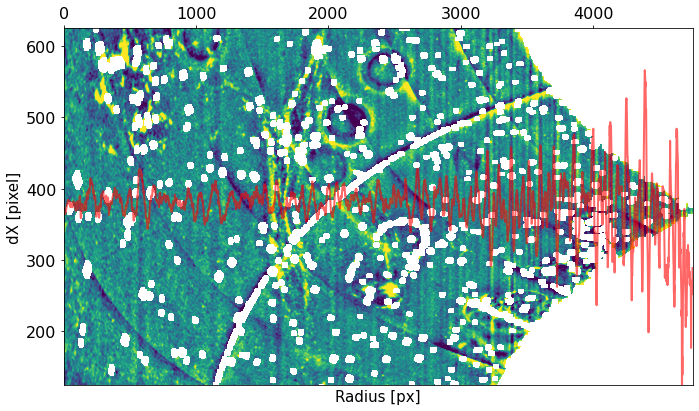

In [72]:
ring_dx.plot_superposition_polar_signal()

In [82]:
# Now make less restrictive mask
mask = np.abs(diff11) > threshold

ring_dx.make_profile(ring_dx.diff,step=2,mask=mask)

## Compare Profiles

Text(0.5, 1.0, 'astrometric shift: dx')

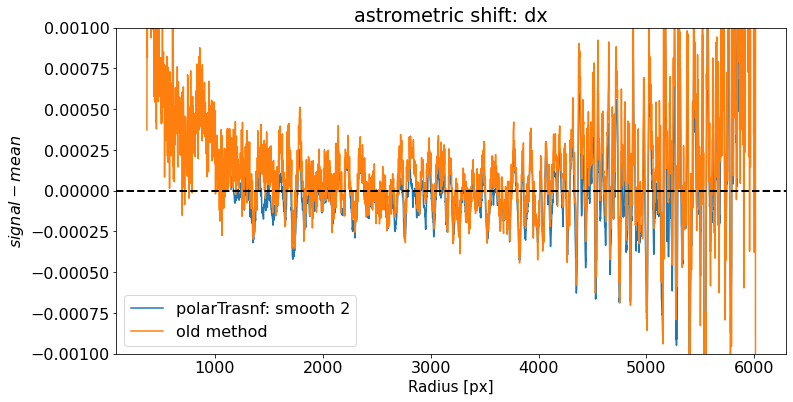

In [83]:
fig, axes = plt.subplots(figsize = (12,6))

# axes.plot(ring_dx.radii,ring_dx.signal0,label='polarTrasnf: no smooth')
axes.plot(ring_dx.radii,ring_dx.signal,label='polarTrasnf: smooth 2')

axes.plot(ring_dx.rmed,ring_dx.signal_bin,label='old method')

# axes.plot(ring_dy.radii,-1*ring_dy.signal,label='y')

axes.axhline(0,color='k',ls='--',lw=2)

axes.set_xlabel("Radius [px]",fontsize=15)
axes.set_ylabel(r'$signal-mean$')
plt.legend()

# axes.set_xlim(3000, 6000)
axes.set_ylim(-0.001,0.001)
axes.set_title('astrometric shift: dx')

In [75]:
v = ring_dx.signal
pos= ring_dx.radii

# v = ring_dx.signal_bin
# pos = ring_dx.rmed

Will analyse the following radial interval: 2100 - 5852 pixels


<ipython-input-76-25187bc3aa0e>:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


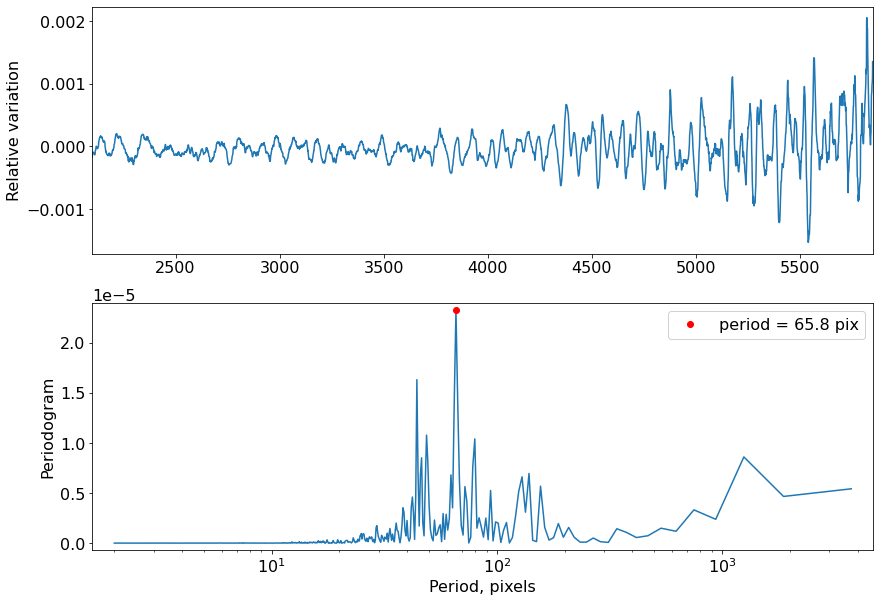

In [76]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

In [486]:
v = ring_dx.signal
pos= ring_dx.radii

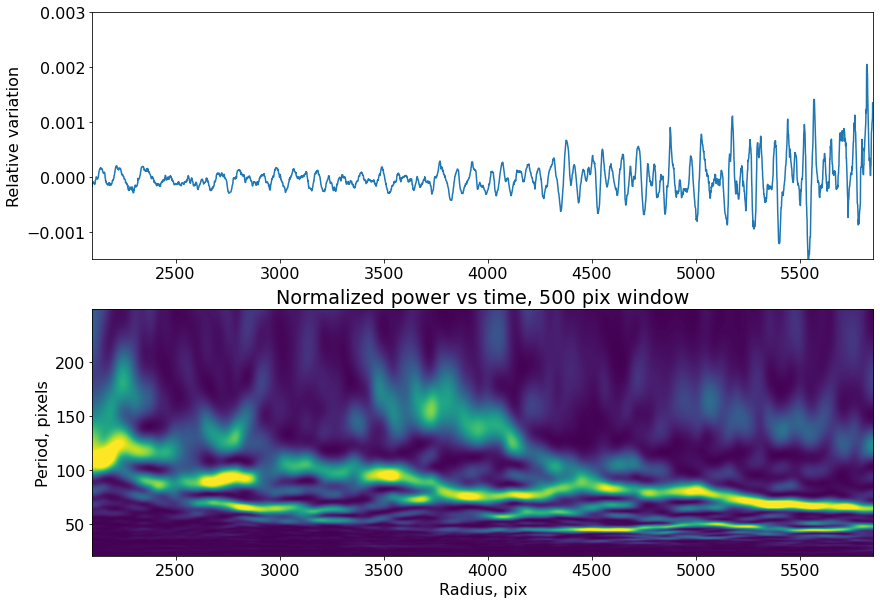

In [77]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')



In [488]:
v = ring_dx.signal_bin
pos = ring_dx.rmed

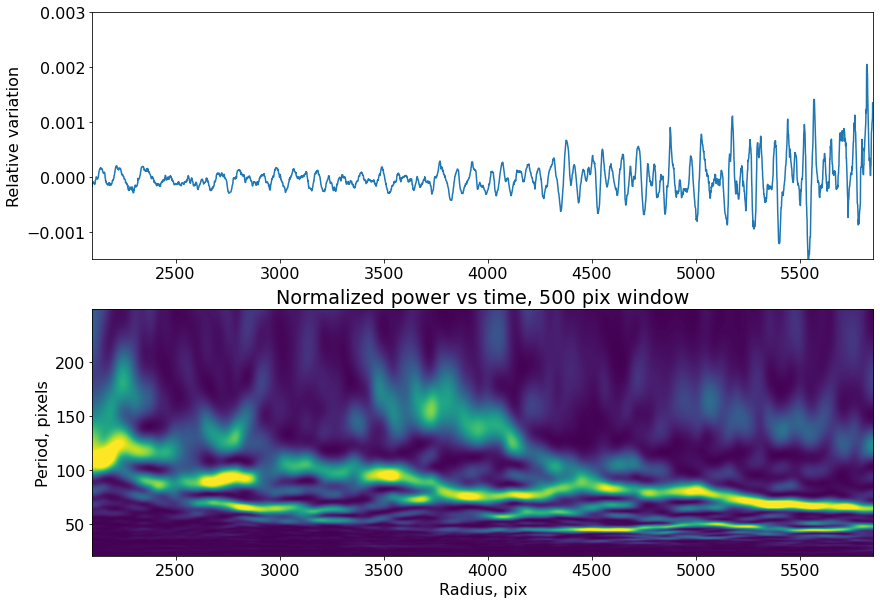

In [78]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


In [490]:
v = ring_dx.signal
pos= ring_dx.radii

<ipython-input-79-b959e844abc4>:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


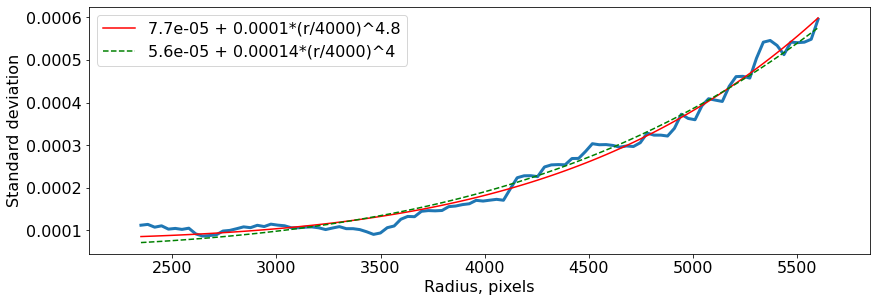

In [79]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)

In [508]:
print(x0,y0)

4464.3619334354025 -460.04802046646745


In [498]:
diffx = (4320-x0)
diffy = (-280-y0)
dr = np.hypot(diffx,diffy)

In [499]:
print(diffx)
print(diffy)
print(dr)

-159.7084855040639
213.35519236300672
266.50935902939204


In [494]:
diffx = (-156+330)
diffy = (4180-4013)

dr = np.hypot(diffx,diffy)

In [495]:
print(diffx)
print(diffy)
print(dr)

174
167
241.17421089328766


## Y direction

In [175]:
ring_dy = tree_ring_tools(sensor='ITL',loc=3)
ring_dy.make_image(itl,'dY',fradius=145)

AttributeError: 'str' object has no attribute 'dT'

In [ ]:
## always run in the following order
ring_dy.apply_high_freq_filter()
ring_dy.apply_gaussian_filter()
ring_dy.apply_mask(threshold=0.05)

ring_dy.set_ylabel(r'dY [pixel]')
ring_dy.display_images()

In [ ]:
ring_dy.yc = 3925

In [ ]:
ring_dy.check_ccd_center_plot(ring_dy.diff2)

In [ ]:
ring_dy.make_polar_transformation(r_cut=(1750,4500),theta_cut=(2950,3450))
ring_dy.check_polar_transfomartion()

In [ ]:
ring_dy.compute_signal()
ring_dy.plot_pannel_image_signal()

In [ ]:
ring_dy.plot_superposition_polar_signal()

### dT

In [ ]:
ring_dt = tree_ring_tools()
ring_dt.make_image(e2v,'dT',fradius=145)

In [ ]:
## always run in the following order
ring_dt.apply_high_freq_filter()
ring_dt.apply_gaussian_filter(downscale=2)
ring_dt.apply_mask(downscale=8)

ring_dt.set_ylabel(r'dT [pixel^2]')
ring_dx.set_levels([-0.002,0.002])
ring_dt.display_images()

In [ ]:
ring_dt.make_profile(ring_dt.diff,step=2)

In [ ]:
ring_dt.check_ccd_center_plot(ring_dt.diff2,ring_dt.xc,ring_dt.yc)

In [ ]:
ring_dt.make_polar_transformation()
ring_dt.check_polar_transfomartion()

In [ ]:
ring_dt.compute_signal()
ring_dt.plot_pannel_image_signal()

In [ ]:
ring_dt.plot_superposition_polar_signal()

In [ ]:
def generate_profiles(self,sensor='e2v',loc=0):
    for var in ['dX','dY','dXX','dYY','dT','dg1','dg2']:
        print('generating profile: %s'%var)
        ring = tree_ring_tools(sensor=sensor,loc=loc)
        ring.make_image(self,var,fradius=145)

        ## image processing: high pass filter and smooth; 
        ## always run in the following order
        ring.apply_high_freq_filter()
        ring.apply_gaussian_filter()
        ring.apply_mask()

        ## warpPolar transformation signal analysis
        ring.make_polar_transformation()
        ring.compute_signal()

        ## bining signal analysis
        ring.make_profile(ring.diff,step=1)
        
        ## save output
        ring.save_profile(var)
        
        #ring.display_images(save=var)

In [ ]:
#generate_profiles(itl,sensor='ITL',loc=3)
#generate_profiles(itl,sensor='e2v',loc=0)

In [ ]:
sensor = 'e2v'
dX = np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dX'))
dY = np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dY'))
dXX= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dXX'))
dYY= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dYY'))
dT = np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dT'))
dg1= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dg1'))
dg2= np.load('profiles/polar_{}_{}.npy'.format(self.sensor,'dg2'))

In [ ]:
## plot profiles

In [ ]:
#plt.figure(figsize=(14,6))
# plt.plot(dX[1])
#plt.plot(dY[1])

#plt.plot(dXX[1])
# plt.plot(dT[1])

# plt.plot(dg1[1])
# plt.plot(dg2[1])

#plt.plot(dX[1])
# plt.xlim(1500,2500)